# Lab 3 — recommender systems

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import math

from operator import add
from collections import Counter

%matplotlib inline
plt.style.use("ggplot")

What does the data look like?

In [2]:
!hdfs dfs -cat /ix/ml-20m/ratings.txt | tail -n 2

{"movieId": 70286, "userId": 138493, "timestamp": 1258126944, "rating": 5.0}
{"movieId": 71619, "userId": 138493, "timestamp": 1255811136, "rating": 2.5}


In [3]:
data = sc.textFile("/ix/ml-20m/ratings.txt").map(json.loads)

In [4]:
userToNRatings = data.map(lambda x: (x["userId"], 0)).countByKey()
movieToNRatings = data.map(lambda x: (x["movieId"], 0)).countByKey()

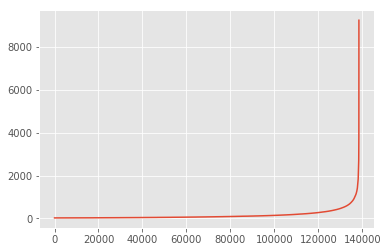

In [5]:
plt.plot(sorted(userToNRatings.values()))
plt.show()

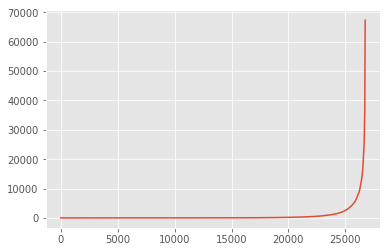

In [6]:
plt.plot(sorted(movieToNRatings.values()))
plt.show()

In [7]:
c,s = data.aggregate((0,0), lambda a,b: (a[0]+1, a[1] + b['rating']), lambda a,b: (a[0]+b[0], a[1]+b[1]))
print(c, s)

20000263 70511498.5


In [8]:
totalAverageRating = s/c
print(totalAverageRating)

3.5255285642993797


In [9]:
trainingSet = data.filter(lambda x: (x["timestamp"] % 5 != 0))
validationSet = data.filter(lambda x: (x["timestamp"] % 5 == 0))

In [10]:
def f(a,b):
    rating = b["rating"]
    current = a.get(b["userId"], -1)
    if (current == -1):
        a[b["userId"]] = 0
    
    a[b["userId"]] += rating
    return a

def g(a,b):
    if ((isinstance(b,dict)) & (isinstance(a,dict))):
        for k,v in b.items():
            current = a.get(k, -1)
            if (current == -1):
                a[k] = v
            else:
                a[k] += v

    return a

In [11]:
trainingUsersRatingSums = trainingSet.aggregate(dict(), f, g)

In [12]:
trainingUsersRatingBiases = {}

for k,v in trainingUsersRatingSums.items():
    trainingUsersRatingBiases[k] = (v / userToNRatings[k]) - totalAverageRating
    
print(trainingUsersRatingBiases[138493])

-0.03223097716801249


In [13]:
avgUserBias = sum(trainingUsersRatingBiases.values()) / len(trainingUsersRatingBiases)

In [14]:
def f(a,b):
    rating = b["rating"]
    current = a.get(b["movieId"], -1)
    if (current == -1):
        a[b["movieId"]] = 0
    
    a[b["movieId"]] += rating - trainingUsersRatingBiases[b["userId"]]
    return a

trainingMoviesSums = trainingSet.aggregate(dict(), f, g)

In [15]:
trainingMovieBiases = {}

for k,v in trainingMoviesSums.items():
    trainingMovieBiases[k] = (v / movieToNRatings[k]) - totalAverageRating

In [16]:
avgMovieBias = sum(trainingMovieBiases.values()) / len(trainingMovieBiases)

In [17]:
def error(data, user="userId", product="movieId", rating="rating"):
    def f(a,b):
        r = b[rating]
        current = a.get(b[user], -1)
        if (current == -1):
            a[b[user]] = 0
        
        mBias = trainingMovieBiases.get(b[product], avgMovieBias)
        uBias = trainingUsersRatingBiases.get(b[user], avgUserBias)
        err = r - (totalAverageRating + mBias + uBias)
        
        a[b[user]] += err * err
        return a

    errorSums = data.aggregate(dict(), f, g)
    errorAverages = {}

    for k,v in errorSums.items():
        errorAverages[k] = math.sqrt(v / userToNRatings[k])
        
    return sum(errorAverages.values()) / len(errorAverages)

In [18]:
error(validationSet)

0.5694905425665281

In [19]:
print(avgMovieBias)
print(avgUserBias)

-0.23377937321896244
-0.6239510801330977


In [20]:
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating

In [21]:
def errorTuples(data):
    def f(a,b):
        r = b[2]
        current = a.get(b[0], -1)
        if (current == -1):
            a[b[0]] = 0
        
        mBias = trainingMovieBiases.get(b[1], avgMovieBias)
        uBias = trainingUsersRatingBiases.get(b[0], avgUserBias)
        err = r - (totalAverageRating + mBias + uBias)
        
        a[b[0]] += err * err
        return a

    errorSums = data.aggregate(dict(), f, g)
    errorAverages = {}

    for k,v in errorSums.items():
        errorAverages[k] = math.sqrt(v / userToNRatings[k])
        
    return sum(errorAverages.values()) / len(errorAverages)

In [22]:
def evaluateModel(rank, numIterations, lmbda):
    # Load and parse the data
    ratings = trainingSet.map(lambda l: Rating(l['userId'], l['movieId'], l['rating']))
    testdata = validationSet.map(lambda l: (l['userId'], l['movieId']))
    # Build the recommendation model using Alternating Least Squares
    model = ALS.train(ratings, rank, numIterations, lmbda)

    # Evaluate the model on training data
    predictions = model.predictAll(testdata)
    return errorTuples(predictions)

In [23]:
#evaluateModel(5, 10, 10**-4)

In [24]:
#evaluateModel(5, 10, 10.0)

In [25]:
#evaluateModel(5, 10, 10**-1)

In [26]:
#evaluateModel(5, 10, 1.0)

In [27]:
evaluateModel(5, 10, 0.9)

0.10175810936134991

In [28]:
!hdfs dfs -cat /ix/ml-20m/movies.txt | tail -n 2

{"genres": ["(no genres listed)"], "movieId": 131260, "title": "Rentun Ruusu (2001)"}
{"genres": ["Adventure", "Fantasy", "Horror"], "movieId": 131262, "title": "Innocence (2014)"}


In [29]:
titleData = dict(sc.textFile("/ix/ml-20m/movies.txt").map(json.loads).map(lambda x: (x['movieId'], x['title'])).collect())

In [30]:
titleData[1]

'Toy Story (1995)'

In [53]:
# Load and parse the data
f = open("my-ratings.txt")
t = [(int(l.split(" ")[3][:-1]), int(l.split(" ")[1][:-1]), int(l.split(" ")[7][:-2])) for l in f.readlines()]
rdd = sc.parallelize(t).map(lambda x: Rating(x[0], x[1], x[2]))
ratings = data.map(lambda l: Rating(l['userId'], l['movieId'], l['rating'])).union(rdd)
# Build the recommendation model using Alternating Least Squares
model = ALS.train(ratings, 10, 10, 0.1)

# Evaluate the model on training data
predictions = model.recommendProducts(123, 10)
myPredictions = model.recommendProducts(138494, 10)

In [54]:
titles = [titleData[x[1]] for x in predictions]
print(titles)

['Marihuana (1936)', 'Bill Hicks: Sane Man (1989)', 'My Brother Tom (2001)', 'I Belong (Som du ser meg) (2012)', 'Bo Burnham: what. (2013)', 'Fitzgerald Family Christmas, The (2012)', 'Peppermint Soda (Diabolo menthe) (1977)', 'Diplomatic Immunity (2009– )', 'Island at War (2004)', 'Sierra, La (2005)']


In [55]:
myTitles = [titleData[x[1]] for x in myPredictions]
print(myTitles)

['No Distance Left to Run (2010)', 'Code Name Coq Rouge (1989)', 'Crazy Stone (Fengkuang de shitou) (2006)', 'Homeboy (1988)', 'Tito and Me (Tito i ja) (1992)', "Ain't in It for My Health: A Film About Levon Helm (2013)", 'Bela Kiss: Prologue (2013)', 'Tom Segura: Completely Normal (2014)', 'Chameleon (Kaméleon) (2008)', 'Willie & Phil (1980)']


In [56]:
print(predictions)
print(myPredictions)

[Rating(user=123, product=126219, rating=5.396886707552426), Rating(user=123, product=130347, rating=4.861697502324844), Rating(user=123, product=117907, rating=4.631412897837729), Rating(user=123, product=112423, rating=4.620398668677047), Rating(user=123, product=116951, rating=4.619680040934755), Rating(user=123, product=98834, rating=4.600453282163684), Rating(user=123, product=98595, rating=4.578306385943188), Rating(user=123, product=107434, rating=4.57203471800904), Rating(user=123, product=107252, rating=4.57203471800904), Rating(user=123, product=54326, rating=4.540245331244707)]
[Rating(user=138494, product=121029, rating=5.879015571957286), Rating(user=138494, product=129536, rating=5.789813086256158), Rating(user=138494, product=77736, rating=5.425567760197204), Rating(user=138494, product=122290, rating=5.379841796551832), Rating(user=138494, product=26793, rating=5.159676995108968), Rating(user=138494, product=117525, rating=5.146577983000588), Rating(user=138494, product